In [ ]:
# Monunt google drive to import KEGG dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import relevant libraries

In [ ]:
# Install Ampligraph library (https://github.com/Accenture/AmpliGraph)
!pip install ampligraph
import ampligraph
from ampligraph.datasets import load_from_csv
import numpy as np
import networkx as nx 
import pandas as pd
from tabulate import tabulate
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
ampligraph.__version__

'1.4.0'

# Import KEGG dataset

In [ ]:
# Load the KEGG dataset
df = load_from_csv('.','drive/My Drive/datasets/KEGG/KEGG50K.txt',sep='\t')
headers = ["Head", "Relationship", "Tail"]
table = tabulate(df[:5], headers, tablefmt="fancy_grid") # tabulate data Reference: https://stackoverflow.com/questions/9712085/numpy-pretty-print-tabular-data
print(table) # output

╒══════════╤══════════════════╤═══════════╕
│ Head     │ Relationship     │ Tail      │
╞══════════╪══════════════════╪═══════════╡
│ hsa04024 │ PATHWAY_GENE     │ HSA:51196 │
├──────────┼──────────────────┼───────────┤
│ D02042   │ DRUG_TARGET_GENE │ HSA:5139  │
├──────────┼──────────────────┼───────────┤
│ N00399   │ NETWORK_GENE     │ HSA:2790  │
├──────────┼──────────────────┼───────────┤
│ hsa04912 │ PATHWAY_GENE     │ HSA:6654  │
├──────────┼──────────────────┼───────────┤
│ H00342   │ DISEASE_GENE     │ HSA:6556  │
╘══════════╧══════════════════╧═══════════╛


The data above exist in (head,relationship,tail) format which is a common way to express knowledge graphs where head and tail nodes are connected by an edge of type relationship.

# Entities and relationship

In [ ]:
entities = np.unique(np.concatenate([df[:, 0], df[:, 2]]))
entities # Entities belongs to (Drugs,Pathways,Network,Gene,Disease)

array(['D00043', 'D00045', 'D00049', ..., 'hsa05414', 'hsa05416',
       'hsa05418'], dtype=object)

In [ ]:
relations = np.unique(df[:, 1])
relations # Total 9 kind of relationship possible

array(['DISEASE_GENE', 'DISEASE_NETWORK', 'DISEASE_PATHWAY',
       'DRUG_EFFICACY_DISEASE', 'DRUG_TARGET_GENE', 'DRUG_TARGET_PATHWAY',
       'NETWORK_GENE', 'NETWORK_PATHWAY', 'PATHWAY_GENE'], dtype=object)

In [ ]:
print("Total numbe of unique entities : ",len(entities))
print("Total number of unique relationship : ",len(relations))

Total numbe of unique entities :  16201
Total number of unique relationship :  9


# Graphical visualisation

In [ ]:
def entrityType(n):         # Utility functon to return entity type
  if n.startswith("h"):
    return "PATHWAY"
  elif n.startswith("D"):
    return "DRUG"
  elif n.startswith("N"):
    return "NETWORK"
  elif n.startswith("HS"):
    return "GENE"
  else:
    return "DISEASE"

In [ ]:
def generateGraph(df,limit):  # Utility function to generate graph or subgraph(limited graph)
  G = nx.Graph()              # empty NetworkX graph
  ID = list()                 # string entity name(ID) and entity type to change color of nodes in graph according to entity type
  entity_type = list()  
  for i in range(0, len(df)):
    if i>limit:
      break
    n1,n2 = df[i][0],df[i][2] # scrap head and tail entities
    G.add_edge(n1,n2)         # add edge in the graph
    t1,t2 = entrityType(n1),entrityType(n2)
    if n1 not in ID:
      ID.append(n1)
      entity_type.append(t1)
    if n2 not in ID:
      ID.append(n2)
      entity_type.append(t2)
  return [G,ID,entity_type]

In [ ]:
d = generateGraph(df,200) # plot a graph with 200 edges max
G,ID,entity_type = d[0],d[1],d[2]

In [ ]:
# Create DF for node characteristics
# Reference for graph visualisation: https://towardsdatascience.com/customizing-networkx-graphs-f80b4e69bedf
carac = pd.DataFrame({'ID':ID,'type':entity_type})
carac[:5]

,ID,type
0,hsa04024,PATHWAY
1,HSA:51196,GENE
2,D02042,DRUG
3,HSA:5139,GENE
4,N00399,NETWORK


In [ ]:
# Make types into categories
carac = carac.set_index('ID')
carac = carac.reindex(G.nodes())
carac['type'] = pd.Categorical(carac['type'])
carac['type'].cat.codes

ID
hsa04024      4
HSA:51196     2
D02042        1
HSA:5139      2
N00399        3
             ..
HSA:3357      2
hsa00590      4
HSA:391013    2
H00891        0
HSA:65080     2
Length: 362, dtype: int8

In [ ]:
# Specify colors
cmap = matplotlib.colors.ListedColormap(['yellow', 'darkorange','crimson','springgreen','royalblue'])

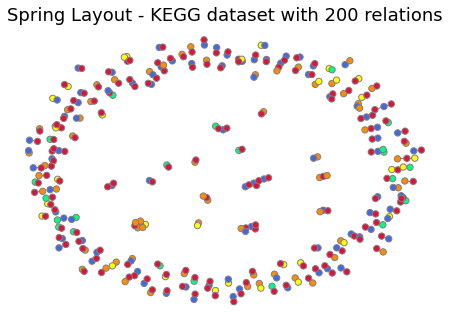

In [ ]:
# Reference for Networkx draw : https://networkx.org/documentation/networkx-1.7/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
nx.draw(G, with_labels=False, node_color=carac['type'].cat.codes, cmap=cmap, node_size = 40, edgecolors='gray',width=0.5)
plt.title('Spring Layout - KEGG dataset with 200 relations', fontsize=18)
plt.savefig('spring-layout-200.png')

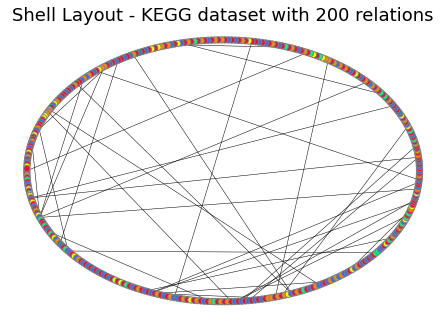

In [ ]:
nx.draw_shell(G, with_labels=False, node_color=carac['type'].cat.codes, cmap=cmap,node_size = 40, edgecolors='gray',width=0.5)
plt.title('Shell Layout - KEGG dataset with 200 relations', fontsize=18)
plt.savefig('shell-layout-200.png')

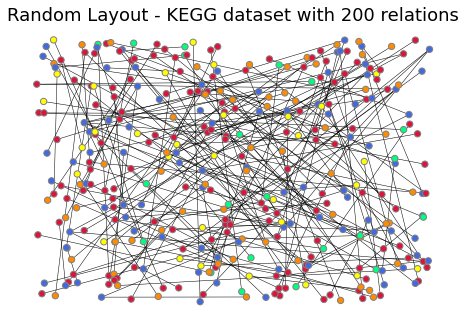

In [ ]:
nx.draw_random(G, with_labels=False, node_color=carac['type'].cat.codes, cmap=cmap, node_size = 40,width=0.5, edgecolors='gray')
plt.title('Random Layout - KEGG dataset with 200 relations', fontsize=18)
plt.savefig('random-layout-200.png')

In [ ]:
print("Number of unique nodes in graph : ",len(G.nodes()))

Number of unique nodes in graph :  362


In [ ]:
d = generateGraph(df,500) # plot a graph with 500 edges max
G,ID,entity_type = d[0],d[1],d[2]
carac = pd.DataFrame({'ID':ID,'type':entity_type})
carac = carac.set_index('ID')
carac = carac.reindex(G.nodes())
carac['type'] = pd.Categorical(carac['type'])
cmap = matplotlib.colors.ListedColormap(['yellow', 'darkorange','crimson','springgreen','royalblue'])

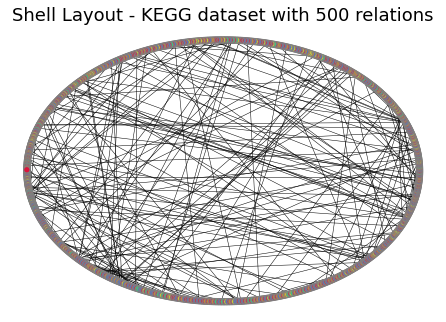

In [ ]:
nx.draw_shell(G, with_labels=False, node_color=carac['type'].cat.codes, cmap=cmap,node_size = 40, edgecolors='gray',width=0.5)
plt.title('Shell Layout - KEGG dataset with 500 relations', fontsize=18)
plt.savefig('shell-layout-500.png')

# Analysis of KEGG full dataset

#### Entity/Relationship counts

In [ ]:
def countEntity(df):            # Utility function to count total entities and there types
  d = defaultdict(int)          # If type not specified will return a dictionary with all entities irrespective of there type
  for i in range(0, len(df)):
     n1,n2 = df[i][0],df[i][2]  # scrap head and tail entities
     t1,t2 = entrityType(n1),entrityType(n2)
     if t1 == "GENE" or t2 == "GENE":
       d["GENE"]+=1
     d[t1]+=1
     d[t1]+=1
     d["TOTAL"]+=1
  return d

entityCount = countEntity(df)
entityCount

defaultdict(int,
            {'DISEASE': 15660,
             'DRUG': 44158,
             'GENE': 50237,
             'NETWORK': 10116,
             'PATHWAY': 56226,
             'TOTAL': 63080})

In [ ]:
def countRelationship(df):      # Utility funcyion to count total relationships and there counts
  d = defaultdict(int)          # If type not specified will return a dictionary with all entities irrespective of there type
  for i in range(0, len(df)):
     r = str(df[i][1])
     d[r]+=1
     d["TOTAL"]+=1
  return d

relationshipCount = countRelationship(df)
relationshipCount

defaultdict(int,
            {'DISEASE_GENE': 5586,
             'DISEASE_NETWORK': 441,
             'DISEASE_PATHWAY': 1803,
             'DRUG_EFFICACY_DISEASE': 2160,
             'DRUG_TARGET_GENE': 12004,
             'DRUG_TARGET_PATHWAY': 7915,
             'NETWORK_GENE': 4534,
             'NETWORK_PATHWAY': 524,
             'PATHWAY_GENE': 28113,
             'TOTAL': 63080})

#### Entities with maximum links in KG

In [ ]:
def maxLinks(df,type=None):     # Utility function to find entity with max links in KG or most active entities
   d = defaultdict(int)         # If type not specified will return a dictionary with all entities irrespective of there type
   for i in range(0, len(df)):
     n1,n2 = df[i][0],df[i][2]  # scrap head and tail entities
     if type == None or entrityType(n1)==type:
      d[n1]+=1
     if type == None or entrityType(n2)==type:
      d[n2]+=1
   return sorted(d.items(), key=lambda kv: -kv[1]) # return a sorted dictionary with entity: no of links

link = maxLinks(df)

In [ ]:
link[:10] # top 10 entities with maximum links

[('hsa04080', 2169),
 ('hsa05200', 737),
 ('hsa04020', 717),
 ('hsa04728', 506),
 ('hsa04010', 482),
 ('hsa04060', 470),
 ('hsa04151', 463),
 ('hsa04740', 448),
 ('hsa04024', 426),
 ('hsa04726', 420)]

In [ ]:
# Specify type in ("PATHWAY","DRUG","NETWORK","GENE","DISEASE")
drug_links = maxLinks(df,"DRUG")
drug_links[:10] # List of most active drugs

[('D00537', 45),
 ('D00981', 39),
 ('D00473', 34),
 ('D00983', 28),
 ('D00292', 28),
 ('D02910', 27),
 ('D00636', 27),
 ('D00088', 26),
 ('D00975', 26),
 ('D00999', 26)]

In [ ]:
with open('drugLinks.txt', 'w') as f:
    for u,v in drug_links:
        f.write("%s\n" % v)

In [ ]:
pathway_links = maxLinks(df,"PATHWAY")
pathway_links[:10] # List of most active pathways

[('hsa04080', 2169),
 ('hsa05200', 737),
 ('hsa04020', 717),
 ('hsa04728', 506),
 ('hsa04010', 482),
 ('hsa04060', 470),
 ('hsa04151', 463),
 ('hsa04740', 448),
 ('hsa04024', 426),
 ('hsa04726', 420)]

In [ ]:
with open('pathwayLinks.txt', 'w') as f:
    for u,v in pathway_links:
        f.write("%s\n" % v)

In [ ]:
gene_links = maxLinks(df,"GENE")
gene_links[:10] # # List of most active genes

[('HSA:1813', 209),
 ('HSA:113', 198),
 ('HSA:154', 189),
 ('HSA:1131', 182),
 ('HSA:3269', 174),
 ('HSA:1129', 160),
 ('HSA:15', 159),
 ('HSA:5290', 158),
 ('HSA:5594', 158),
 ('HSA:1128', 158)]

In [ ]:
with open('geneLinks.txt', 'w') as f:
    for u,v in gene_links:
        f.write("%s\n" % v)

In [ ]:
disease_links = maxLinks(df,"DISEASE")
disease_links[:10] # List of most active diseases

[('H01633', 100),
 ('H00409', 89),
 ('H01563', 66),
 ('H00031', 66),
 ('H00527', 66),
 ('H00048', 60),
 ('H00020', 56),
 ('H00773', 55),
 ('H00606', 55),
 ('H01360', 50)]

In [ ]:
with open('diseaseLinks.txt', 'w') as f:
    for u,v in disease_links:
        f.write("%s\n" % v)

In [ ]:
network_links = maxLinks(df,"NETWORK")
network_links[:10] # List of most active networks

[('N00060', 47),
 ('N00056', 47),
 ('N00053', 46),
 ('N00059', 41),
 ('N00267', 38),
 ('N00115', 38),
 ('N00019', 37),
 ('N00409', 35),
 ('N00221', 34),
 ('N00157', 33)]

In [ ]:
with open('networkLinks.txt', 'w') as f:
    for u,v in network_links:
        f.write("%s\n" % v)

# Graph with maximum relationship entities

In [ ]:
G = nx.Graph()              # empty NetworkX graph
ID = list()                 # string entity name(ID) and entity type to change color of nodes in graph according to entity type
entity_type = list()  
popularEntitiesCounter = drug_links[:5] + pathway_links[:5] + gene_links[:5] + disease_links[:5] + network_links[:5]
popularEntities = []
for k,v in popularEntitiesCounter:
  popularEntities.append(k)

for i in range(0, len(df)):
  n1,n2 = df[i][0],df[i][2] # scrap head and tail entities
  if n1 in popularEntities or n2 in popularEntities:
    G.add_edge(n1,n2)         # add edge in the graph
    t1,t2 = entrityType(n1),entrityType(n2)
    if n1 not in ID:
      ID.append(n1)
      entity_type.append(t1)
    if n2 not in ID:
      ID.append(n2)
      entity_type.append(t2)

In [ ]:
carac = pd.DataFrame({'ID':ID,'type':entity_type})
carac[:5]

,ID,type
0,H00787,DISEASE
1,hsa04080,PATHWAY
2,N00060,NETWORK
3,HSA:23401,GENE
4,HSA:54361,GENE


In [ ]:
# Make types into categories
carac = carac.set_index('ID')
carac = carac.reindex(G.nodes())
carac['type'] = pd.Categorical(carac['type'])
carac['type'].cat.codes

ID
H00787       0
hsa04080     4
N00060       3
HSA:23401    2
HSA:54361    2
            ..
D02220       1
H01532       0
D03887       1
D10325       1
D07436       1
Length: 4004, dtype: int8

In [ ]:
# Specify colors
cmap = matplotlib.colors.ListedColormap(['yellow', 'darkorange','crimson','springgreen','royalblue'])

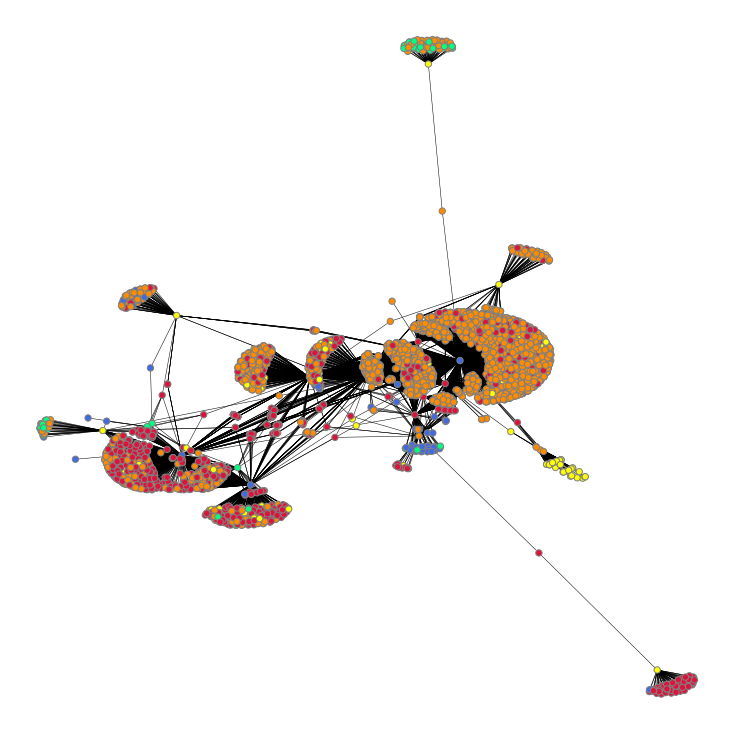

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(3,figsize=(10,10)) 
nx.draw_spring(G, with_labels=False, node_color=carac['type'].cat.codes, cmap=cmap,node_size = 40, edgecolors='gray',width=0.5)
#plt.title('Spring Layout', fontsize=18)
plt.show()
plt.savefig('KG-Section-Spring.png')

# Subgraph for drug  D00537

In [ ]:
G = nx.Graph()              # empty NetworkX graph
ID = list()                 # string entity name(ID) and entity type to change color of nodes in graph according to entity type
entity_type = list()  
popularEntitiesCounter = drug_links[:1] 
popularEntities = []
for k,v in popularEntitiesCounter:
  popularEntities.append(k)


for i in range(0, len(df)):
  n1,n2 = df[i][0],df[i][2] # scrap head and tail entities
  if n1 in popularEntities or n2 in popularEntities:
    G.add_edge(n1,n2)         # add edge in the graph
    t1,t2 = entrityType(n1),entrityType(n2)
    if n1 not in ID:
      ID.append(n1)
      entity_type.append(t1)
    if n2 not in ID:
      ID.append(n2)
      entity_type.append(t2)

In [ ]:
carac = pd.DataFrame({'ID':ID,'type':entity_type})
carac[:5]

,ID,type
0,D00537,DRUG
1,HSA:2890,GENE
2,HSA:2892,GENE
3,HSA:2561,GENE
4,HSA:2900,GENE


In [ ]:
# Make types into categories
carac = carac.set_index('ID')
carac = carac.reindex(G.nodes())
carac['type'] = pd.Categorical(carac['type'])
carac['type'].cat.codes

ID
D00537       1
HSA:2890     2
HSA:2892     2
HSA:2561     2
HSA:2900     2
HSA:6329     2
HSA:77       2
HSA:2564     2
HSA:2566     2
HSA:776      2
hsa04080     3
HSA:5587     2
HSA:2567     2
HSA:6328     2
HSA:6331     2
HSA:2565     2
H01813       0
HSA:762      2
hsa04727     3
HSA:2559     2
HSA:11280    2
HSA:2891     2
hsa04724     3
HSA:2898     2
HSA:775      2
HSA:2558     2
HSA:2563     2
HSA:2897     2
HSA:760      2
HSA:2562     2
HSA:6335     2
HSA:2557     2
HSA:2560     2
hsa04020     3
HSA:6323     2
HSA:6326     2
HSA:2554     2
HSA:6336     2
HSA:2568     2
HSA:2899     2
HSA:778      2
HSA:6334     2
HSA:2555     2
HSA:290      2
HSA:289      2
HSA:2556     2
dtype: int8

In [ ]:
# Specify colors
cmap = matplotlib.colors.ListedColormap(['lightskyblue','lawngreen','plum','orange','yellow'])

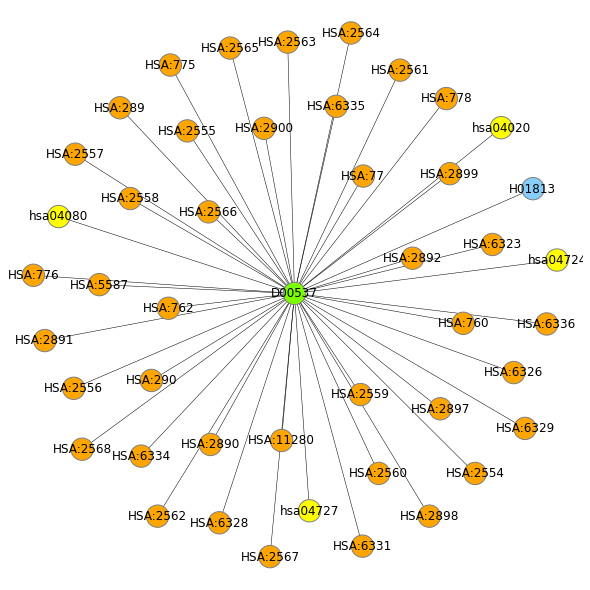

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(3,figsize=(8,8)) 
nx.draw_spring(G, with_labels=True, node_color=carac['type'].cat.codes, cmap=cmap,node_size = 500, edgecolors='gray',width=0.5)
plt.show()
plt.savefig('KG-Drug-D00537.png')

In [ ]:
G = nx.Graph()              # empty NetworkX graph
ID = list()                 # string entity name(ID) and entity type to change color of nodes in graph according to entity type
entity_type = list()  
popularEntitiesCounter = drug_links[:1] 
connectingDrugs = ['D00280','D00354','D00537','D01253','D05775','D10915']
popularEntities = []
for k,v in popularEntitiesCounter:
  popularEntities.append(k)


for i in range(0, len(df)):
  n1,n2 = df[i][0],df[i][2] # scrap head and tail entities
  if n1 in popularEntities or n2 in popularEntities or (n1=='H01813' and n2 in connectingDrugs) or (n2=='H01813' and n1 in connectingDrugs):
    G.add_edge(n1,n2)         # add edge in the graph
    t1,t2 = entrityType(n1),entrityType(n2)
    if n1 not in ID:
      ID.append(n1)
      entity_type.append(t1)
    if n2 not in ID:
      ID.append(n2)
      entity_type.append(t2)

In [ ]:
carac = pd.DataFrame({'ID':ID,'type':entity_type})
carac[:5]
# Make types into categories
carac = carac.set_index('ID')
carac = carac.reindex(G.nodes())
carac['type'] = pd.Categorical(carac['type'])
carac['type'].cat.codes

ID
D00537       1
HSA:2890     2
HSA:2892     2
HSA:2561     2
D05775       1
H01813       0
HSA:2900     2
HSA:6329     2
HSA:77       2
HSA:2564     2
HSA:2566     2
HSA:776      2
hsa04080     3
HSA:5587     2
HSA:2567     2
HSA:6328     2
HSA:6331     2
HSA:2565     2
HSA:762      2
hsa04727     3
HSA:2559     2
HSA:11280    2
HSA:2891     2
hsa04724     3
HSA:2898     2
HSA:775      2
HSA:2558     2
HSA:2563     2
HSA:2897     2
HSA:760      2
HSA:2562     2
HSA:6335     2
HSA:2557     2
D00354       1
HSA:2560     2
hsa04020     3
HSA:6323     2
HSA:6326     2
D00280       1
HSA:2554     2
HSA:6336     2
HSA:2568     2
D01253       1
HSA:2899     2
HSA:778      2
HSA:6334     2
HSA:2555     2
HSA:290      2
HSA:289      2
HSA:2556     2
dtype: int8

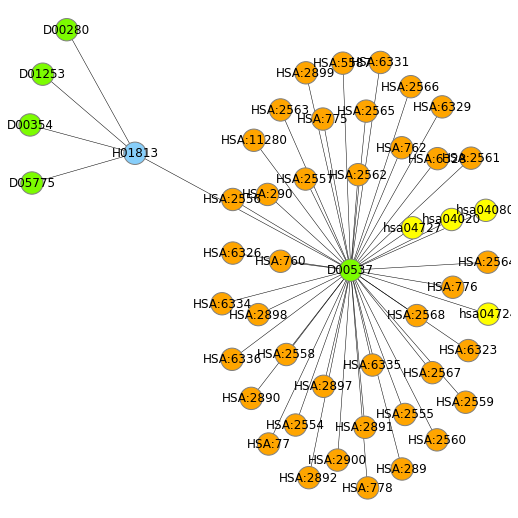

<Figure size 432x288 with 0 Axes>

In [ ]:
# Specify colors
cmap = matplotlib.colors.ListedColormap(['lightskyblue','lawngreen','plum','orange','yellow'])
plt.figure(3,figsize=(7,7)) 
nx.draw_spring(G, with_labels=True, node_color=carac['type'].cat.codes, cmap=cmap,node_size = 500, edgecolors='gray',width=0.5)
plt.show()
plt.savefig('KG-Drug-D00537-conn.png')